<a href="https://colab.research.google.com/github/ilucas75/BTflow/blob/dev/RD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install

In [1]:
!pip install pdfminer.six
!pip install spacy
!pip install tabula-py
!python -m spacy download fr_core_news_md

     |████████████████████████████████| 5.6MB 5.9MB/s 
     |████████████████████████████████| 13.7MB 221kB/s 
     |████████████████████████████████| 10.4MB 5.6MB/s 
     |████████████████████████████████| 88.6MB 1.2MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338488 sha256=989e614df903a33e606010b76e53b04dd14509d4934b17beb84d5865f7ebf677
  Stored in directory: /tmp/pip-ephem-wheel-cache-mdrxdmdp/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


## Upload PDF and Json

In [42]:
from google.colab import files

uploaded = files.upload()
all_files = ' '.join(list(uploaded.keys()))
!mkdir -p data
!mv {all_files} ./data/

Saving 0070C022_220C0700.json to 0070C022_220C0700.json
Saving 0340C022_220C0430.json to 0340C022_220C0430.json
Saving 0510C022_220C0150.json to 0510C022_220C0150.json
Saving 0540C022_220C0450.json to 0540C022_220C0450.json
Saving 0620C022_220C0260.json to 0620C022_220C0260.json
Saving 0810C022_220C0180.json to 0810C022_220C0180.json
Saving 0820C022_220C0280.json to 0820C022_220C0280.json
Saving 0900C022_220C0090.json to 0900C022_220C0090.json
Saving 0940C022_220C0490.json to 0940C022_220C0490.json
Saving 0960C022_220C0690.json to 0960C022_220C0690.json
Saving 0980C022_220C0890.json to 0980C022_220C0890.json
Saving 1040C022_220C0401.json to 1040C022_220C0401.json
Saving 1080C022_220C0801.json to 1080C022_220C0801.json
Saving 1090C022_220C0901.json to 1090C022_220C0901.json
Saving 1200C022_220C0021.json to 1200C022_220C0021.json
Saving 1270C022_220C0721.json to 1270C022_220C0721.json
Saving 1360C022_220C0631.json to 1360C022_220C0631.json
Saving 1380C022_220C0831.json to 1380C022_220C08

## Table PDF

In [0]:
from tabula import read_pdf
import pandas as pd

def extract_tables(filename):
  dfs = read_pdf(list_pdf[0], pages='all')
  tables_str = []
  for df in dfs:
  if not df.empty:
    table_str = ""
    for c in df.columns:
      if not "Unnamed:" in c:
        table_str += c + " "
    for _, r in df.iterrows():
      for c in df.columns:
        if pd.notna(r[c]):
          table_str += r[c] + " "
    tables_str.append(table_str)
  return dfs, tables_str

Got stderr: Mar 31, 2020 7:14:33 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Mar 31, 2020 7:14:33 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>
Mar 31, 2020 7:14:33 AM org.apache.pdfbox.pdmodel.font.PDTrueTypeFont <init>



## Extract PDF text

In [0]:
import io
 
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

In [0]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
 
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
 
        text = fake_file_handle.getvalue()
 
    # close open handles
    converter.close()
    fake_file_handle.close()
 
    if text:
        return text

## Load PDF and Json

In [51]:
import json
import os 

data = {}
data_label = {}
data_no_label = {}

for f in os.listdir('./data'):
  try:
    f = os.path.join('./data', f)
    name, ext = os.path.splitext(f)
    if ext == '.pdf' and name not in data:
      text = extract_text_from_pdf(f)
      if "Déclaration de franchissement de seuils" in text:
        x =  {"file": f, "text": text}
        data[name] = x
        data_no_label[name] = x
    elif ext == '.json':
      with open(f) as fd:
        x = json.load(fd)
        data[name] = x
        if 'entities' in x and len(x['entities']) != 0:
          data_label[name] = x
          if name in data_no_label:
            del data_no_label[name]
        else:
          data_no_label[name] = x
  except Exception as e:
    print("Error : ", f)
    print(e)
data = [v for k, v in sorted(data.items(), key=lambda t: t[0])]
data_label = [v for k, v in sorted(data_label.items(), key=lambda t: t[0])]
data_no_label = [v for k, v in sorted(data_no_label.items(), key=lambda t: t[0])]
print(len(data), "texts with", len(data_label), "labeled and", len(data_no_label), 'to label')

117 texts with 117 labeled and 0 to label


## Labellisation

In [0]:
import IPython
from google.colab import output
import os

class AnnotWidget():
  def __init__(self, to_annot, start=0, model=None):
    self.to_annot = to_annot
    self.cur = start
    self.model = model
    self.colors_labels = [
        ("rgb(255, 0, 0)", "ISSUER", 'A'),
        ("rgb(255, 0, 255)", "FIRM", 'Z'),
        ("rgb(0, 255, 255)", "NUMBER", 'E'),
        ("rgb(160, 160, 255)", "PERCENT", 'R'),
        ("rgb(192, 192, 192)", "TYPE", 'T'),
        ("rgb(255, 255, 0)", "DIRECTION", 'S'),
        ("rgb(0, 255, 0)", "DATE", 'D'),
        ("rgb(255, 180, 180)", "FILIALE", 'F'),
        ("rgb(230, 171, 0)", 'INSTRUMENT', 'G')
      ]
    self.controls = ""
    for c, l, k in self.colors_labels:
      self.controls += '''<button id="key_'''+k+'''" style="background-color: '''+\
        c+''';" onclick='document.execCommand("backColor", false, "'''+c+'''")'>'''+l+" ("+k+")</button>"

  def text_entities_to_html(self):
    if 'entities' not in self.to_annot[self.cur] or len(self.to_annot[self.cur]['entities']) == 0:
      return self.to_annot[self.cur]["text"]
    res = ""
    offset = 0
    text = self.to_annot[self.cur]["text"]
    for ent_s, ent_e, label in self.to_annot[self.cur]['entities']:
      res += text[offset:ent_s]
      res += '''<span style="background-color: '''+ self.get_color(label) + '''">'''
      res += text[ent_s:ent_e]
      res += "</span>"
      offset = ent_e
    res += text[offset:]
    return res

  def run(self):
    display(IPython.display.HTML('''
    <p>'''+str(self.cur) + "/" + str(len(self.to_annot)) + '''</p>
    <fieldset>
    '''+ self.controls +'''
      <button id="key_Q" onclick="document.execCommand('removeFormat', false, null)">remove (Q)</button>
      <button id="key_P" onclick="google.colab.kernel.invokeFunction('notebook.Prediction');">pred (P)</button>
      <button id='prev'>prev</button>
      <button id='next'>next</button>
    </fieldset>
    <div id="ed" contenteditable="true">'''+self.text_entities_to_html()+'''</div>
    <script>
      function change(dir) {
        children = document.querySelector("#ed").childNodes;
        res = [];
        offset = 0;
        for (var i = 0; i < children.length; i++) {
          next_offset = offset + children[i].textContent.length;
          if (children[i].nodeType != Node.TEXT_NODE) {
            rgb = children[i].style.backgroundColor
            res.push([offset, next_offset, rgb])
          }
          offset = next_offset;
        }
        google.colab.kernel.invokeFunction('notebook.SaveEntities', [res, dir]);
        document.querySelector('#ed').innerHTML = next_text;
      };
      document.querySelector('#prev').onclick = () => {
        change(-1);
      };
      document.querySelector('#next').onclick = () => {
        change(1);
      };
      document.querySelector('#ed').onkeydown = (ev) => {
        ev.preventDefault();
      };
      document.querySelector('#ed').onkeypress = (ev) => {
        ev.preventDefault();
      };
      document.querySelector('#ed').onkeyup = (ev) => {
        ev.preventDefault();
        button_id = "#key_" + String.fromCharCode(ev.keyCode);
        button = document.querySelector(button_id)
        if (button) {
          button.click();
        }
      };
    </script>
    '''))
    output.register_callback('notebook.SaveEntities', self.save_entities)
    output.register_callback('notebook.Console', self.console)
    output.register_callback('notebook.Prediction', self.prediction)

  def get_color(self, label):
    for c, l, _ in self.colors_labels:
        if l == label:
          return c

  def get_label(self, color):
    for c, l, _ in self.colors_labels:
        if c == color:
          return l

  def save_entities(self, res, inc=1):
    self.to_annot[self.cur]['entities'] = []
    for ent_s, ent_e, color in res:
      self.to_annot[self.cur]['entities'].append((ent_s, ent_e, self.get_label(color)))
    if len(self.to_annot[self.cur]['entities']) != 0:
      name, _ = os.path.splitext(self.to_annot[self.cur]['file'])
      with open('./data/'+name+'.json', 'w+') as f:
        json.dump(self.to_annot[self.cur], f)
    output.clear()
    if (self.cur < len(self.to_annot) and inc == 1) or (self.cur > 0 and inc == -1):
      self.cur += inc
    self.run()

  def console(self, s):
    print(s)

  def prediction(self):
    if (self.model is not None) and (('entities' not in self.to_annot[self.cur]) or (len(self.to_annot[self.cur]['entities']) == 0)):
      doc = self.model(self.to_annot[self.cur]["text"])
      self.to_annot[self.cur]['entities'] = []
      for ent in doc.ents:
        self.to_annot[self.cur]['entities'].append([ent.start_char, ent.end_char, ent.label_])
      output.clear()
      self.run()


In [0]:
w = AnnotWidget(data, start=0, model=None)

In [0]:
w.run()

In [0]:
data = {x['file'] : x for x in data}
data_label = {x['file'] : x for x in data_label}
data_no_label = {x['file'] : x for x in data_no_label}
for x in w.to_annot:
  if 'entities' in x and len(x['entities']) != 0:
    data[x['file']] = x
    data_label[x['file']] = x
    if x['file'] in data_no_label:
      del data_no_label[x['file']]
data = [v for k, v in sorted(data.items(), key=lambda t: t[0])]
data_label = [v for k, v in sorted(data_label.items(), key=lambda t: t[0])]
data_no_label = [v for k, v in sorted(data_no_label.items(), key=lambda t: t[0])]
print(len(data), "texts with", len(data_label), "labeled and", len(data_no_label), 'to label')

NameError: ignored

## Download Json

In [50]:
from google.colab import files

!zip dataset.zip ./data/*.json
files.download('dataset.zip') 

updating: data/0070C022_220C0700.json (deflated 66%)
updating: data/0340C022_220C0430.json (deflated 59%)
updating: data/0510C022_220C0150.json (deflated 51%)
updating: data/0540C022_220C0450.json (deflated 62%)
updating: data/0620C022_220C0260.json (deflated 50%)
updating: data/0810C022_220C0180.json (deflated 69%)
updating: data/0820C022_220C0280.json (deflated 60%)
updating: data/0900C022_220C0090.json (deflated 74%)
updating: data/0940C022_220C0490.json (deflated 57%)
updating: data/0960C022_220C0690.json (deflated 69%)
updating: data/0980C022_220C0890.json (deflated 54%)
updating: data/1040C022_220C0401.json (deflated 61%)
updating: data/1080C022_220C0801.json (deflated 51%)
updating: data/1090C022_220C0901.json (deflated 66%)
updating: data/1200C022_220C0021.json (deflated 58%)
updating: data/1270C022_220C0721.json (deflated 64%)
updating: data/1360C022_220C0631.json (deflated 65%)
updating: data/1380C022_220C0831.json (deflated 55%)
updating: data/1430C022_220C0341.json (deflate

## NER

In [52]:
def split_train_test(split=0.33):
  train_data = []
  labels = {}
  for x in data_label:
    entities = []
    for ent_s, ent_e, ent_t in x["entities"]:
      if ent_t not in labels:
        labels[ent_t] = 0
      labels[ent_t] += 1
      entities.append((ent_s, ent_e, ent_t))
    train_data.append((x['text'], {'entities' : entities}))
  split = int(split * len(train_data))
  test_data = train_data[:split]
  train_data = train_data[split:]
  return train_data, test_data, labels

train_data, test_data, labels = split_train_test()
print('Train data :', len(train_data), '\ttest data :', len(test_data))
print(labels)

Train data : 79 	test data : 38
{'DATE': 550, 'ISSUER': 838, 'FIRM': 477, 'DIRECTION': 146, 'PERCENT': 332, 'TYPE': 1001, 'NUMBER': 573, 'INSTRUMENT': 163}


### Spacy

In [53]:
import random
import spacy
from spacy.util import minibatch, compounding
import fr_core_news_md

n_iter=40
nlp = fr_core_news_md.load()
ner = nlp.get_pipe("ner")
for label in labels:
  ner.add_label(label)
optimizer = nlp.resume_training()
pipe_exceptions = ["ner"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
with nlp.disable_pipes(*other_pipes):  # only train NER
  sizes = compounding(1.0, 4.0, 1.001)
  # batch up the examples using spaCy's minibatch
  for itn in range(n_iter):
    random.shuffle(train_data)
    batches = minibatch(train_data, size=sizes)
    losses = {}
    for batch in batches:
      texts, annotations = zip(*batch)
      nlp.update(texts, annotations, sgd=optimizer, drop=0.35, losses=losses)
    print("Losses", losses)
  score = nlp.evaluate(test_data)

Losses {'ner': 20231.34433838669}
Losses {'ner': 18340.741899143904}
Losses {'ner': 17857.186364645837}
Losses {'ner': 17668.226727746078}
Losses {'ner': 17265.24770634109}
Losses {'ner': 17135.048662730493}
Losses {'ner': 17180.88277628104}
Losses {'ner': 16911.57567672385}
Losses {'ner': 16769.740140885}
Losses {'ner': 16864.795457154512}
Losses {'ner': 16859.796931985766}
Losses {'ner': 16617.746460482478}
Losses {'ner': 16707.345898337662}
Losses {'ner': 16746.916716065258}
Losses {'ner': 16849.36925823614}
Losses {'ner': 16565.322683393955}
Losses {'ner': 16818.434626042843}
Losses {'ner': 16682.93277066946}
Losses {'ner': 16611.993291169405}
Losses {'ner': 16737.987910632044}
Losses {'ner': 16755.577106922865}
Losses {'ner': 16673.837993472815}
Losses {'ner': 16698.555912733078}
Losses {'ner': 16850.41422891617}
Losses {'ner': 16704.92412686348}
Losses {'ner': 16851.35186123848}
Losses {'ner': 16855.683705568314}
Losses {'ner': 16776.16757197678}
Losses {'ner': 17023.30854511261}

In [54]:
score.scores

{'ents_f': 91.7948717948718,
 'ents_p': 90.86294416243655,
 'ents_per_type': {'DATE': {'f': 98.4126984126984, 'p': 96.875, 'r': 100.0},
  'DIRECTION': {'f': 100.0, 'p': 100.0, 'r': 100.0},
  'FIRM': {'f': 76.1904761904762,
   'p': 66.66666666666666,
   'r': 88.88888888888889},
  'INSTRUMENT': {'f': 40.0, 'p': 50.0, 'r': 33.33333333333333},
  'ISSUER': {'f': 90.2439024390244,
   'p': 86.04651162790698,
   'r': 94.87179487179486},
  'NUMBER': {'f': 90.0, 'p': 100.0, 'r': 81.81818181818183},
  'PERCENT': {'f': 97.67441860465117, 'p': 100.0, 'r': 95.45454545454545},
  'TYPE': {'f': 94.62365591397848,
   'p': 95.65217391304348,
   'r': 93.61702127659575}},
 'ents_r': 92.74611398963731,
 'las': 0.0,
 'las_per_type': {'': {'f': 0.0, 'p': 0.0, 'r': 0.0}},
 'tags_acc': 0.0,
 'textcat_score': 0.0,
 'textcats_per_cat': {},
 'token_acc': 100.0,
 'uas': 0.0}

In [0]:
from spacy import displacy
doc = nlp(data[0]['text'])

displacy.render(doc, style='ent', jupyter=True)

In [0]:
def spacy_predict(data):
  pred_data = []
  for d in data:
    entities = []
    doc = nlp(d[0])
    for ent in doc.ents:
      entities.append((ent.start_char, ent.end_char, ent.label_))
    pred_data.append((d[0], {'entities' : entities}))
  return pred_data

### Hugging face

In [140]:
!pip install git+https://github.com/huggingface/transformers
!pip install seqeval

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-7dzqt3gj
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-7dzqt3gj
     |████████████████████████████████| 3.8MB 6.5MB/s 
  Created wheel for transformers: filename=transformers-2.8.0-cp36-none-any.whl size=585132 sha256=b0a31d1397c9ce48a7ef09c2a07389119e303be250fafbb15b43c10f6d3b491c
  Stored in directory: /tmp/pip-ephem-wheel-cache-__cs0cgi/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
  Found existing installation: tokenizers 0.5.2
    Uninstalling tokenizers-0.5.2:
      Successfully uninstalled tokenizers-0.5.2


#### Train

In [105]:
! mkdir -p hugging-data
! mkdir -p hugging-res
! git clone https://github.com/huggingface/transformers

Cloning into 'transformers'...
remote: Enumerating objects: 24824, done.
remote: Total 24824 (delta 0), reused 0 (delta 0), pack-reused 24824
Receiving objects: 100% (24824/24824), 14.91 MiB | 12.67 MiB/s, done.
Resolving deltas: 100% (17441/17441), done.


In [0]:
def split_to_sequences(data, sep='  '):
  sequences = []
  for d in data:
    offset = 0
    start_ent = 0
    ent_idx = 0
    for seq in d[0].split(sep):
      if len(seq) != 0:
        entities = []
        next_offset = offset + len(seq) + len(sep)
        while ent_idx < len(d[1]['entities']):
          ent_s, ent_e, ent_t = d[1]['entities'][ent_idx]
          if ent_s < next_offset:
            entities.append((max(ent_s - offset, 0), min(ent_e - offset, len(seq)), ent_t))
            if ent_e < next_offset:
              ent_idx += 1
            else:
              break
          else:
            break
        sequences.append((seq, {'entities' : entities}))
        offset = next_offset
      else:
        offset += len(sep)
  return sequences

In [0]:
def transform_label(data, tokenizer, split_tok='##', unk_tok='[UNK]'):
  X = []
  Y = []
  for text, labels in data:
    offset = 0
    idx_ent = 0
    tokens = tokenizer.tokenize(text)
    y = []
    for tok in tokens:
      if idx_ent >= len(labels['entities']):
        y = y + ['O']*(len(tokens) - len(y))
        break
      offset_tok = len(split_tok) if split_tok is not None and tok.startswith(split_tok) else 0
      tok_s = None
      if tok == unk_tok:
        y.append('O')
        continue
      for offset_tok in range(offset_tok, len(tok)):
        while offset < len(text) and text[offset] != tok[offset_tok]:
          offset += 1
        if tok_s is None:
          tok_s = offset
        offset += 1
      tok_e = offset
      ent_s, ent_e, ent_t = labels['entities'][idx_ent]
      if tok_s is not None and tok_s >= ent_s:
        y.append(ent_t)
        if tok_e >= ent_e:
          idx_ent += 1
      else:
        y.append('O')
    X.append(tokens)
    Y.append(y)
  return X, Y

In [0]:
def labels_to_file(filename, labels):
  with open(filename, 'w+') as f:
    for l in labels:
      f.write(l + '\n')
  
def data_to_file(filename, X, Y):
  with open(filename, 'w+') as f:
    for x, y in zip(X, Y):
      for tex, lab in zip(x, y):
        f.write(tex + ' ' + lab + '\n')
      f.write('\n')

In [108]:
from transformers import AutoTokenizer

labels = ['ISSUER', 'FIRM', 'NUMBER', 'PERCENT', 'TYPE', 'DIRECTION', 'DATE', 'FILIALE', 'INSTRUMENT', 'O']
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
train_seq = split_to_sequences(train_data)
test_seq = split_to_sequences(test_data)
X_train, Y_train = transform_label(train_seq, tokenizer)
X_test, Y_test = transform_label(test_seq, tokenizer)
labels_to_file('hugging-data/labels.txt', labels)
data_to_file('hugging-data/train.txt', X_train, Y_train)
data_to_file('hugging-data/dev.txt', X_test, Y_test)


In [0]:
cmd = """
    python run_ner.py
    --model_name bert-base-multilingual-cased
    --output_dir /content/hugging-res
    --overwrite_output_dir
    --data_dir /content/hugging-data
    --labels /content/hugging-data/labels.txt
    --max_seq_length 256
    --per_gpu_train_batch_size 16
    --num_train_epochs 6
    --save_steps 300
    --logging_steps 1
    --do_train
    --do_eval
""".replace('\n', ' ')

In [154]:
%cd /content/transformers/examples/ner/
! {cmd}
%cd /content/

/content/transformers/examples/ner
2020-04-27 10:54:42.523551: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
04/27/2020 10:54:44 - INFO - transformers.training_args -   PyTorch: setting up devices
04/27/2020 10:54:44 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
04/27/2020 10:54:44 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir='/content/hugging-res', overwrite_output_dir=True, do_train=True, do_eval=True, do_predict=False, evaluate_during_training=False, per_gpu_train_batch_size=16, per_gpu_eval_batch_size=8, gradient_accumulation_steps=1, learning_rate=5e-05, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=6.0, max_steps=-1, warmup_steps=0, logging_dir=None, logging_first_step=False, logging_steps=1, save_steps=300, save_total_limit=None, no_cuda=False, seed=42, fp16=False, fp16_o

In [0]:
checkpoints=!echo /content/hugging-res/checkpoint-*
last_checkpoint = max([int(ch.split('-')[-1]) for ch in checkpoints])
! mv /content/hugging-res/checkpoint-{last_checkpoint} hugging-model
!rm -r /content/hugging-res/*

#### Predict

In [0]:
def retokenize(data):
  sentences = []
  for seq in data:
    sentence = ''
    ent_s = None
    ent_e = None
    ent_t = None
    offset = 0
    next_offset = 0
    entities = []
    for tok, lab in seq:
      if tok in ['[SEP]', '[UNK]', '[CLS]']:
        continue
      else:
        sep = ''
        if tok.startswith('##'):
          sep = ''
          tok = tok[2:]
        sentence += sep + tok
        next_offset = offset + len(tok) + len(sep)
        if lab != 'O' and ent_t == lab:
          ent_e = next_offset
        else:
          if ent_t is not None:
            entities.append((ent_s, ent_e, ent_t))
            ent_s, ent_e, ent_t = None, None, None
          if lab != 'O':
            ent_s, ent_e, ent_t = offset, next_offset, lab
      offset = next_offset
    if ent_t is not None:
      entities.append((ent_s, ent_e, ent_t))
    sentences.append((sentence, entities))
  return sentences

In [0]:
def find_pos_ent(data, pred_data):
  new_data = []
  sentences = retokenize(pred_data)
  idx_sent = 0
  for text, _ in data:
    new_entities = []
    new_start = None
    idx_ent = 0
    offset = 0
    for i in range(len(text)):
      if text[i] == sentences[idx_sent][0][offset]:
        if idx_ent < len(sentences[idx_sent][1]):
          ent_s, ent_e, ent_t = sentences[idx_sent][1][idx_ent]
          if offset == ent_s:
            new_start = i
          elif ent_e == offset + 1:
            new_entities.append((new_start, i + 1, ent_t))
            idx_ent += 1
        offset += 1
        if offset >= len(sentences[idx_sent][0]):
          offset = 0
          idx_ent = 0
          idx_sent += 1
          if idx_sent >= len(sentences):
            break
    new_data.append((text, {'entities': new_entities}))
  return new_data

In [0]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch

def hugging_predict(data):
  model = AutoModelForTokenClassification.from_pretrained("/content/hugging-model")
  tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
  pred_data = []
  sequences = split_to_sequences(data)
  for sequence in sequences:
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence[0])))
    inputs = tokenizer.encode(sequence[0], return_tensors="pt")
    outputs = model(inputs)[0]
    predictions = torch.argmax(outputs, dim=2)
    pred_data.append([(token, labels[prediction]) for token, prediction in zip(tokens, predictions[0].tolist())])
  return find_pos_ent(data, pred_data)

### NLTK

In [258]:
! pip install nltk

In [0]:
import nltk
!wget 'https://nlp.stanford.edu/software/stanford-ner-2018-10-16.zip'
!unzip stanford-ner-2018-10-16.zip
nltk.download('punkt')

In [0]:
prop = '''
trainFile = train/dummy-french-corpus.tsv
serializeTo = dummy-ner-model-french.ser.gz
map = word=0,answer=1

useClassFeature=true
useWord=true
useNGrams=true
noMidNGrams=true
maxNGramLeng=6
usePrev=true
useNext=true
useSequences=true
usePrevSequences=true
maxLeft=1
useTypeSeqs=true
useTypeSeqs2=true
useTypeySequences=true
wordShape=chris2useLC
useDisjunctive=true
'''
! mkdir -p stanford-ner-2018-10-16/train
! echo '{prop}' > stanford-ner-2018-10-16/train/prop.txt

In [0]:
from nltk.tokenize import word_tokenize

class nltkTokenizer():
  def tokenize(text):
    return word_tokenize(text)

X_train, Y_train = transform_label(train_data, nltkTokenizer, split_tok=None, unk_tok=None)
data_to_file('stanford-ner-2018-10-16/train/dummy-french-corpus.txt', X_train, Y_train)

In [284]:
%cd stanford-ner-2018-10-16/
!java -cp "stanford-ner.jar:lib/*" -mx4g edu.stanford.nlp.ie.crf.CRFClassifier -prop train/prop.txt
%cd /content/

/content/stanford-ner-2018-10-16
Invoked on Mon Apr 27 14:33:42 UTC 2020 with arguments: -prop train/prop.txt
useTypeSeqs2=true
noMidNGrams=true
trainFile=train/dummy-french-corpus.tsv
maxNGramLeng=6
maxLeft=1
serializeTo=dummy-ner-model-french.ser.gz
wordShape=chris2useLC
useDisjunctive=true
useClassFeature=true
useNGrams=true
useNext=true
usePrev=true
useTypeySequences=true
usePrevSequences=true
useTypeSeqs=true
useSequences=true
map=word=0,answer=1
useWord=true
numFeatures = 40464
Time to convert docs to feature indices: 2.6 seconds
numClasses: 9 [0=O,1=DATE,2=ISSUER,3=FIRM,4=DIRECTION,5=PERCENT,6=TYPE,7=NUMBER,8=INSTRUMENT]
numDocuments: 79
numDatums: 29727
numFeatures: 40464
Time to convert docs to data/labels: 0.9 seconds
numWeights: 1160208
QNMinimizer called on double function of 1160208 variables, using M = 25.
               An explanation of the output:
Iter           The number of iterations
evals          The number of function evaluations
SCALING        <D> Diagonal scali

In [0]:
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize

def nltk_predict(data):
  st = StanfordNERTagger('/content/stanford-ner-2018-10-16/dummy-ner-model-french.ser.gz',
                        '/content/stanford-ner-2018-10-16/stanford-ner.jar',
                        encoding='utf-8')
  pred_data = []
  for text, _ in data:
    tokenized_text = word_tokenize(text)
    pred_data.append(st.tag(tokenized_text))
  return find_pos_ent(data, pred_data)

### Evaluate NER

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_ner(true_data, pred_data):
  y_true = []
  y_pred = []
  true = split_to_sequences(true_data, ' ')
  pred = split_to_sequences(pred_data, ' ')
  labels = {}
  for p, t in zip(pred, true):
    t_ent_s, t_ent_e, t_ent_t = t[1]['entities'][0] if len(t[1]['entities']) != 0 else (None, None, 'None')
    p_ent_s, p_ent_e, p_ent_t = p[1]['entities'][0] if len(p[1]['entities']) != 0 else (None, None, 'None')
    if t_ent_t != 'None':
      labels[t_ent_t] = 0
    y_true.append(t_ent_t)
    y_pred.append(p_ent_t)
  
  labels = list(labels.keys())
  labels_with_none = labels + ['None']
  print(classification_report(y_pred=y_pred, y_true=y_true, labels=labels_with_none))
  matrix = confusion_matrix(y_pred=y_pred, y_true=y_true, labels=labels_with_none, normalize='true')
  df_cm = pd.DataFrame(matrix, index=labels_with_none, columns=labels_with_none)
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

        DATE       0.99      1.00      1.00       607
      ISSUER       0.95      0.88      0.91       469
        FIRM       0.81      0.81      0.81       462
   DIRECTION       1.00      1.00      1.00        92
     PERCENT       0.98      0.94      0.96       111
        TYPE       0.96      0.99      0.97       511
      NUMBER       0.99      0.95      0.97       524
  INSTRUMENT       0.64      0.73      0.69       131
        None       0.98      0.98      0.98      9617

    accuracy                           0.97     12524
   macro avg       0.92      0.92      0.92     12524
weighted avg       0.97      0.97      0.97     12524



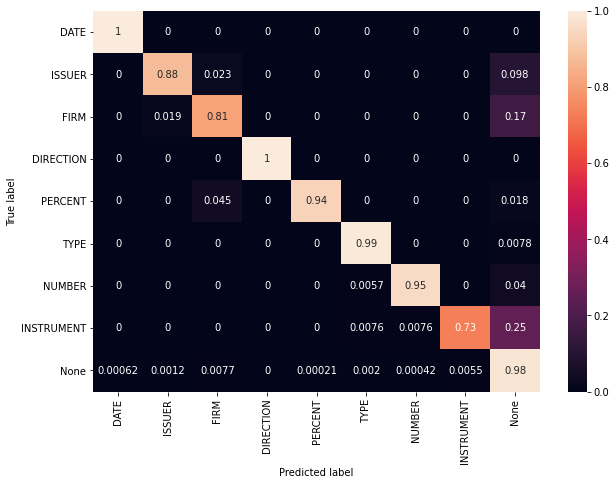

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

        DATE       0.99      0.93      0.96       607
      ISSUER       0.99      0.63      0.77       469
        FIRM       0.69      0.93      0.79       462
   DIRECTION       1.00      1.00      1.00        92
     PERCENT       0.97      0.93      0.95       111
        TYPE       0.95      0.95      0.95       511
      NUMBER       0.99      0.90      0.94       524
  INSTRUMENT       0.86      0.60      0.70       131
        None       0.97      0.99      0.98      9617

    accuracy                           0.96     12524
   macro avg       0.93      0.87      0.89     12524
weighted avg       0.96      0.96      0.96     12524



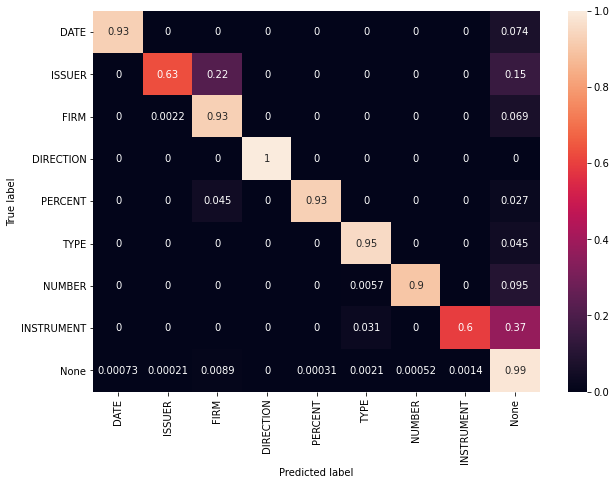

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


<IPython.core.display.Javascript object>

AttributeError: ignored

In [292]:
from google.colab import widgets

tab = widgets.TabBar(['Spacy', 'Hugging Face', 'NLTK'])
with tab.output_to(0):
  prediction = spacy_predict(test_data)
  evaluate_ner(test_data, prediction)
with tab.output_to(1):
  prediction = hugging_predict(test_data)
  evaluate_ner(test_data, prediction)
with tab.output_to(2):
  prediction = nltk_predict(test_data)
  evaluate_ner(test_data, prediction)

## Extract Data

In [0]:
import pandas as pd

def link_quantities(text, entities, dist_max=15):
  linked = []
  quantities = []
  pos_prev = None
  quant_type = None
  prev_type = None
  for ent_start, ent_end, ent_type in entities:
    ent_text = text[ent_start:ent_end]
    if ent_type in ['NUMBER', 'PERCENT']:
      if (prev_type == ent_type and ent_start - prev_pos < dist_max):
        quantities.append(ent_text)
        quant_type = ent_type
      else:
        quantities = [ent_text]
        quant_type = ent_type
    elif ent_type == 'TYPE':
      if len(quantities) != 0 and (prev_type in ['NUMBER', 'PERCENT', 'TYPE']) and ent_start - prev_pos < dist_max:
        linked.append((quantities, ent_text, quant_type))
      else:
        quantities = []
    prev_type = ent_type
    prev_pos = ent_end
  return pd.DataFrame.from_records(linked, columns=['quants', 'unit', 'type'])

def get_quantities(df, idx):
  if idx >= len(df):
    return None
  s = df.iloc[idx]
  ret = []
  for q in s['quants']:
    if s['type'] == 'PERCENT':
      if '/' in q:
        num, den = q.split('/')
        ret.append(float(num)/float(den)*100.0)
      else:
        ret.append(float(q.replace(',', '.').replace('%', '')))
    else:
      if 'aucun' in q:
        ret.append(0)
      else:
        ret.append(int(q.replace(' ', '')))
  return ret



def exctract_info(text, entities):
  df = pd.DataFrame.from_records([{'text':text[s:e], 'start':s, 'end':e, 'type':t} for s, e, t in entities])
  ret = {}
  ret['Issuer'] = df[df['type'] == 'ISSUER']['text'].value_counts().index[0]
  ret['Firms'] = df[df['type'] == 'FIRM']['text'].value_counts(sort=False).index.to_list()
  dir_idx = df[df['type'] == 'DIRECTION'].index[0]
  ret['Direction'] = df[df['type'] == 'DIRECTION']['text'].iloc[0]
  ret['Date'] = df[(df['type'] == 'DATE') & (df.index > dir_idx)]['text'].iloc[0]
  ret['Filiales'] = df[df['type'] == 'FILIALE']['text'].value_counts(sort=False).index.to_list()
  ret['Instruments'] = df[df['type'] == 'INSTRUMENT']['text'].value_counts(sort=False).index.to_list()
  df_q = link_quantities(text, entities)
  cap = df_q[(df_q['type'] == 'PERCENT') & df_q['unit'].str.contains('capital')]
  vote = df_q[(df_q['type'] == 'PERCENT') & df_q['unit'].str.contains('vote')]
  ret['Action'] = get_quantities(df_q[(df_q['type'] == 'NUMBER') & df_q['unit'].str.contains('action')], 0)
  ret['ThreasholdCapital'] = get_quantities(cap, 0)
  ret['Capital'] = get_quantities(cap, 1)
  ret['ThreasholdVote'] = get_quantities(vote, 0)
  ret['Vote'] = get_quantities(vote, 1)

  print(ret)


for d in test_data:
  exctract_info(d[0], d[1]['entities'])

{'Issuer': 'ALTRAN TECHNOLOGIES', 'Firms': ['Bank of America Corporation'], 'Direction': 'en hausse', 'Date': '17 février 2020', 'Filiales': ['Merrill Lynch International', 'BofA Securities Europe SA'], 'Instruments': ['cash-settled equity swap'], 'Action': [14377895], 'ThreasholdCapital': [5.0], 'Capital': [5.59], 'ThreasholdVote': [5.0], 'Vote': [5.58]}
{'Issuer': 'VALEO', 'Firms': ['VALEO', 'BlackRock, Inc.'], 'Direction': 'en baisse', 'Date': '29 janvier 2020', 'Filiales': [], 'Instruments': ['contracts for differences'], 'Action': [11878005], 'ThreasholdCapital': [5.0], 'Capital': [4.93], 'ThreasholdVote': [5.0], 'Vote': [4.81]}
{'Issuer': 'ALTRAN TECHNOLOGIES', 'Firms': ['Société Générale'], 'Direction': 'en baisse', 'Date': '9 janvier 2020', 'Filiales': [], 'Instruments': [], 'Action': None, 'ThreasholdCapital': [5.0], 'Capital': None, 'ThreasholdVote': [5.0], 'Vote': None}
{'Issuer': 'INTERNATIONAL FLAVORS & FRAGRANCES INC', 'Firms': ['BlackRock Inc.'], 'Direction': 'en hausse'